In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import corner
from jnkepler.jaxttv import jaxttv, elements_to_pdic, params_to_elements
from jax.config import config
import numpyro, jax
config.update('jax_enable_x64', True)
numpyro.set_platform('cpu')
num_chains = 1
numpyro.set_host_device_count(num_chains)
print ('# jax device count:', jax.local_device_count())

# jax device count: 1


In [2]:
npl = 2
datadir = "./kep9/"
names = ['ttv-b.txt', 'ttv-c.txt']

In [3]:
tcobs, errorobs, p_init = [], [], []
for n in names:
    fname = datadir + n
    _d = pd.read_csv(fname, delim_whitespace=True)
    tnum, tc, tcerr = np.array(_d[['N', 'T0', 'sigma_T0']]).T
    tcerr /= 1440.
    tcobs.append(tc)
    errorobs.append(tcerr)
    p, t0 = np.polyfit(tnum, tc, deg=1)
    p_init.append(p)
p_init = np.array(p_init)

In [4]:
import itertools
tclist = list(itertools.chain.from_iterable(tcobs))
print (p_init[0], p_init[0]/40.)
print (np.min(tclist), np.max(tclist))

19.246113950740423 0.48115284876851055
136.30647 1587.53394


In [5]:
dt = 0.4 #/ 2.
t_start, t_end = 135, 1590.
jttv = jaxttv(t_start, t_end, dt)

# sympletic integrator is used.


In [6]:
jttv.set_tcobs(tcobs, p_init, errorobs=errorobs)

# integration starts at:           135.00
# first transit time in data:      136.31
# last transit time in data:       1587.53
# integration ends at:             1590.00
# integration time step:           0.4000 (1/48 of innermost period)


initial objective function: 63542598.52 (107 data)

running LM optimization...
objective function: 144.24 (107 data)
# elapsed time (least square): 9.9 sec


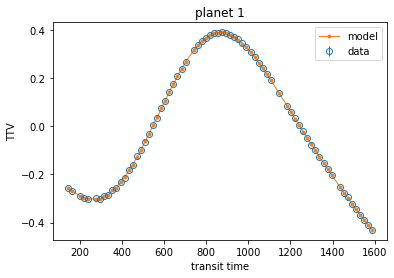

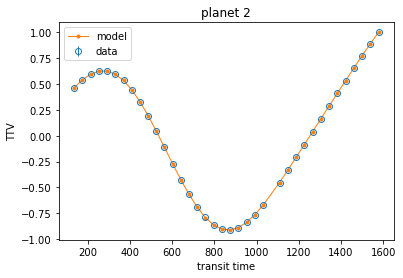

In [7]:
params_best = jttv.optim(amoeba=False, mmax=1e-3, emax=0.3)

In [9]:
tc = jttv.check_prec(params_best)

# fractional energy error (symplectic, dt=4.00e-01): 1.48e-08
# fractional energy error (Hermite, dt=1.92e-02): -1.65e-11
# max difference in tc: 7.32e-05 days (6.33 sec)


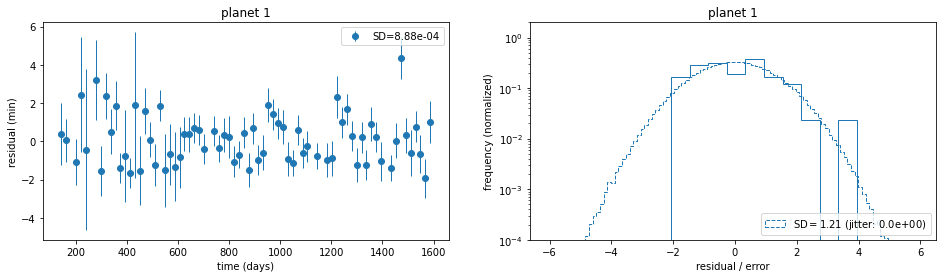

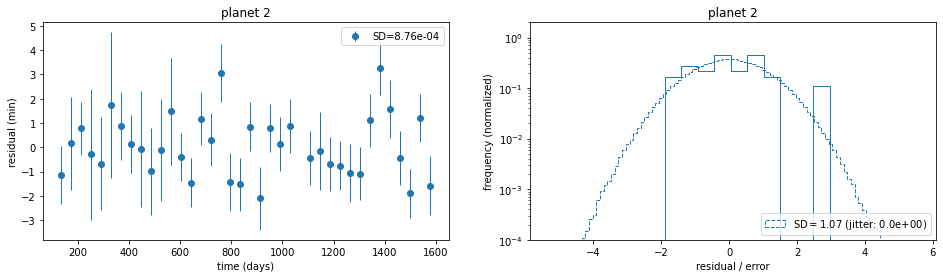

In [12]:
# cf. Figure 6/7 left in Borasto+2019 arXiv:1901.05471
jttv.check_residuals(tc)

In [19]:
pdic = pd.DataFrame(elements_to_pdic(*params_to_elements(params_best, jttv.nplanet)))
print (pdic)

       pmass     period     ecosw     esinw  cosi  lnode         tic  \
0  42.478831  19.228894  0.063156 -0.003492   0.0   -0.0  144.249596   
1  29.252116  39.037223 -0.066577  0.013400   0.0   -0.0  136.307117   

        ecc     omega    lnmass      mass      cosw      sinw  
0  0.063253 -0.055242 -8.966730  0.000128  0.998475 -0.055214  
1  0.067912  2.942973 -9.339784  0.000088 -0.980340  0.197317  


In [18]:
%timeit jttv.get_ttvs(*params_to_elements(params_best, jttv.nplanet))

3.95 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
from numpyro.infer import init_to_value
import numpyro.distributions as dist
import jax.random as random

tic_guess = jnp.array([_tcobs[0] for _tcobs in jttv.tcobs])
p_guess = jnp.array(jttv.p_init)
ones = jnp.ones_like(p_guess)

pdic_init = elements_to_pdic(*params_to_elements(params_best, jttv.nplanet), 
                             outkeys=['period', 'ecc', 'cosw', 'sinw', 'cosi', 'lnode', 'tic', 'lnmass', 'mass'])
init_strategy = init_to_value(values=pdic_init)

def model(dp=5e-1, dtic=1e-1, emax=0.5, mmin=1e-7, mmax=1e-3, uniform_mass=False, tcjitter=None):
    tic = numpyro.sample("tic", dist.Uniform(low=tic_guess-dtic, high=tic_guess+dtic))
    period = numpyro.sample("period", dist.Uniform(low=p_guess-dp, high=p_guess+dp))
    ecc = numpyro.sample("ecc", dist.Uniform(low=ones*0, high=ones*emax))

    cosw = numpyro.sample("cosw", dist.Normal(scale=ones))
    sinw = numpyro.sample("sinw", dist.Normal(scale=ones))
    omega = jnp.arctan2(sinw, cosw)
    numpyro.deterministic("omega", omega)

    lnode = ones * 0
    numpyro.deterministic("lnode", lnode)
    cosi = ones * 0
    numpyro.deterministic("cosi", cosi)
    if uniform_mass:
        mass = numpyro.sample("mass", dist.Uniform(low=ones*mmin, high=ones*mmax))
        numpyro.deterministic("lnmass", jnp.log(mass))
    else:
        lnmass = numpyro.sample("lnmass", dist.Uniform(low=ones*jnp.log(mmin), high=ones*jnp.log(mmax)))
        mass = jnp.exp(lnmass)
        numpyro.deterministic("mass", mass)

    #elements = jnp.array([period, ecc*cosw, ecc*sinw, cosi, lnode, tic]).T
    elements = jnp.array([period, ecc*jnp.cos(omega), ecc*jnp.sin(omega), cosi, lnode, tic]).T
    numpyro.deterministic("elements", elements)

    tcmodel, ediff = jttv.get_ttvs(elements, jnp.hstack([1., mass]))
    if tcjitter is not None:
        lntcjitter = numpyro.sample("lntcjitter", dist.Uniform(low=-10, high=jnp.log(tcjitter)))
        tcjitter = numpyro.deterministic("tcjitter", jnp.exp(lntcjitter))
        tcerrmodel = jnp.sqrt(jttv.errorobs_flatten**2 + tcjitter**2)
    else:
        tcerrmodel = jttv.errorobs_flatten
    numpyro.deterministic("ediff", ediff)
    numpyro.deterministic("tcmodel", tcmodel)
    numpyro.sample("obs", dist.Normal(loc=tcmodel, scale=tcerrmodel), obs=jttv.tcobs_flatten)

In [31]:
pdic_init

{'period': DeviceArray([19.22889368, 39.03722328], dtype=float64),
 'cosi': DeviceArray([0., 0.], dtype=float64),
 'lnode': DeviceArray([-0., -0.], dtype=float64),
 'tic': DeviceArray([144.24959577, 136.30711677], dtype=float64),
 'ecc': DeviceArray([0.06325278, 0.06791213], dtype=float64),
 'lnmass': DeviceArray([-8.96672999, -9.33978393], dtype=float64),
 'mass': DeviceArray([1.27584714e-04, 8.78584173e-05], dtype=float64),
 'cosw': DeviceArray([ 0.99847454, -0.98033978], dtype=float64),
 'sinw': DeviceArray([-0.05521403,  0.1973168 ], dtype=float64)}

In [32]:
kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9, init_strategy=init_strategy)

In [37]:
nw, ns, linm, tcjitter = 100, 100, True, None  # dt=0.4, 1h20min
#nw, ns = 500, 2000 # dt=0.2, 33h (not long enough)
#nw, ns, tcjitter = 100, 100, 1e-3  # dt=0.4, tcjitter=1e-3, 1h20min
#nw, ns, tcjitter = 500, 1500, 1e-3  # dt=0.4, tcjitter=1e-3, 13hr

In [38]:
assert num_chains <= jax.local_device_count()
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns, num_chains=num_chains)

In [44]:
output = "kep9/dt%.1f_"%jttv.dt
if not linm:
    output += "logm"
if tcjitter is not None:
    output += "jit_"
output += "nw%d_ns%d_"%(nw, ns)
if num_chains > 1:
    output += "c%d_"%num_chains

In [46]:
output

In [51]:
import os, dill
posterior = output + "mcmc.pkl"
if os.path.exists(posterior):
    print (posterior + " loaded.")
    mcmc = dill.load(open(posterior, 'rb'))
else:
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, mmin=0, mmax=5e-4, uniform_mass=linm, tcjitter=tcjitter)
    with open(base+"mcmc.pkl", "wb") as f:
        dill.dump(mcmc, f)

kep9/linm_n500x4_mcmc.pkl loaded.


In [52]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   cosw[0]      1.04      0.13      1.03      0.86      1.25      2.24      4.28
   cosw[1]     -0.99      0.03     -0.99     -1.02     -0.94      2.98      2.36
    ecc[0]      0.06      0.01      0.06      0.05      0.07      2.17      4.46
    ecc[1]      0.07      0.00      0.07      0.06      0.07      3.03      2.36
   mass[0]      0.00      0.00      0.00      0.00      0.00      3.33      1.88
   mass[1]      0.00      0.00      0.00      0.00      0.00      3.31      1.89
 period[0]     19.23      0.00     19.23     19.23     19.23      5.78      1.34
 period[1]     39.04      0.00     39.04     39.04     39.04      4.38      1.48
   sinw[0]     -0.06      0.01     -0.05     -0.08     -0.04      2.36      2.92
   sinw[1]      0.20      0.01      0.20      0.19      0.21      3.28      1.98
    tic[0]    144.25      0.00    144.25    144.25    144.25     12.54      1.23
    tic[1]    136.31      0

In [53]:
samples = mcmc.get_samples()

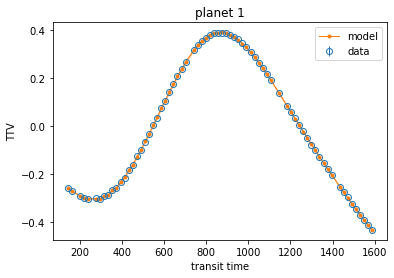

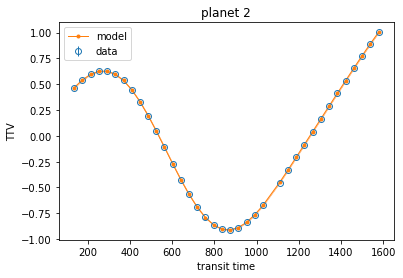

In [55]:
idx = samples['ediff']==samples['ediff']
mmodel, smodel = jnp.mean(samples['tcmodel'][idx], axis=0), jnp.std(samples['tcmodel'][idx], axis=0)
jttv.quicklook(mmodel, sigma=smodel, save=output+"postm")

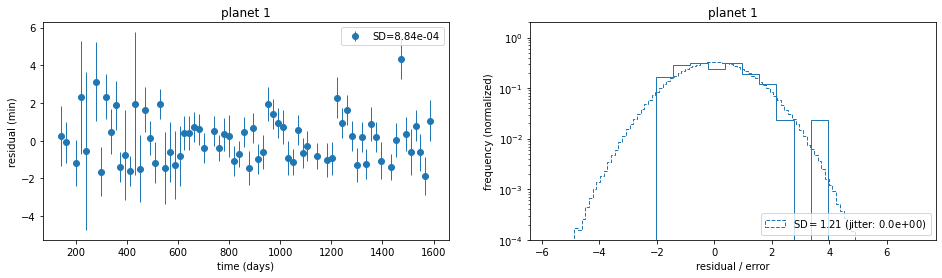

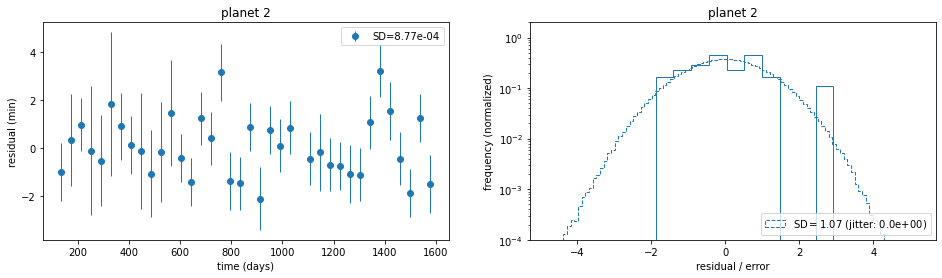

In [56]:
jttv.check_residuals(mmodel)

(array([ 27.,  89., 116., 238., 267., 408., 489., 268.,  71.,  27.]),
 array([-7.84793399, -7.84487556, -7.84181714, -7.83875871, -7.83570029,
        -7.83264187, -7.82958344, -7.82652502, -7.82346659, -7.82040817,
        -7.81734974]),
 <BarContainer object of 10 artists>)

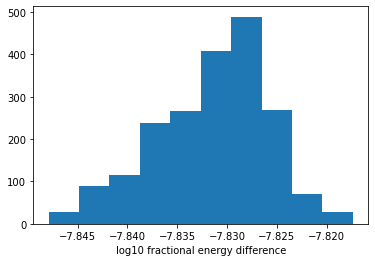

In [58]:
plt.xlabel("log10 fractional energy difference")
plt.hist(np.log10(np.abs(samples['ediff'])))

In [59]:
M_earth = 3.0034893e-6
samples['pmass'] = samples['mass'] / M_earth
keys = ['pmass', 'tic', 'period', 'ecc', 'omega']

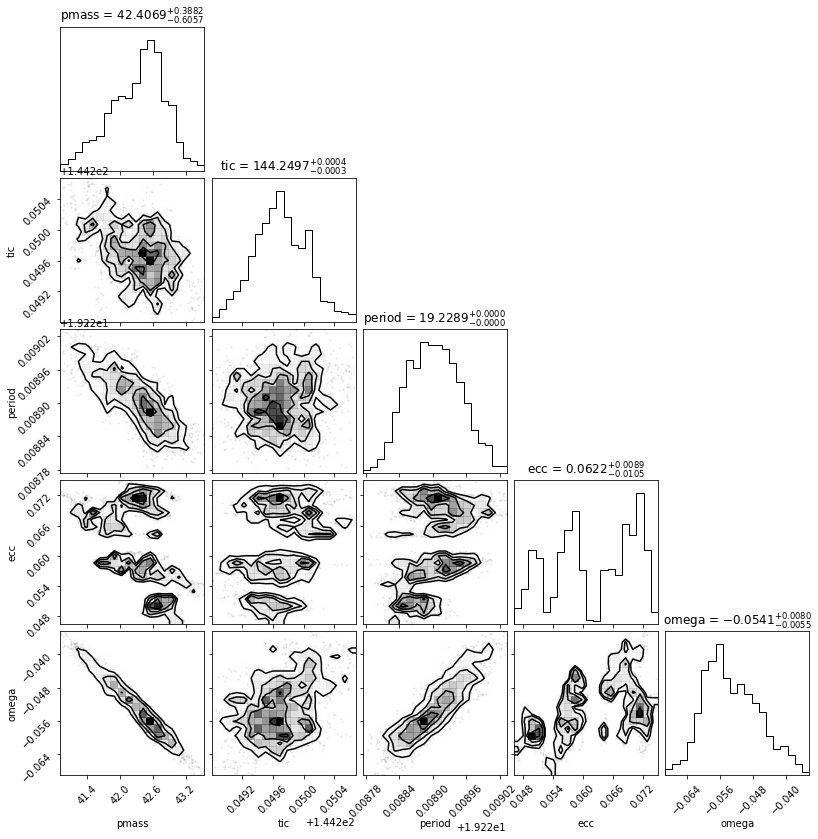

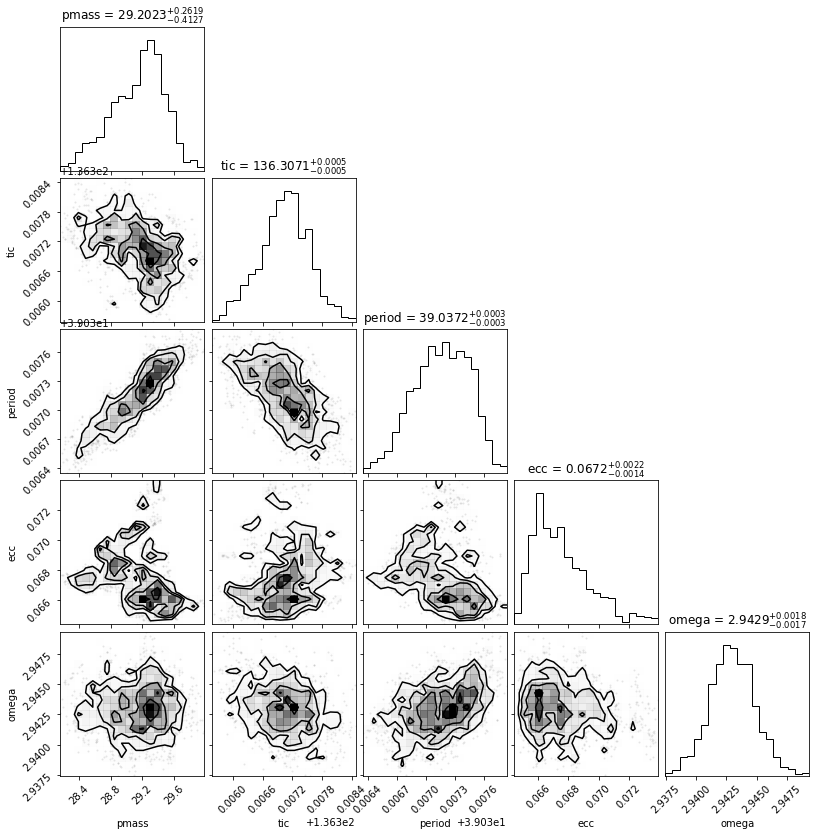

In [60]:
for j in range(jttv.nplanet):
    hyper = pd.DataFrame(data=dict(zip(keys, [samples[k][:,j] for k in keys])))
    if tcjitter is not None:
        hyper['lntcjitter'] = samples['lntcjitter']
        labels = keys + ['lntcjitter']
    else:
        labels = keys
    fig = corner.corner(hyper, labels=labels, show_titles=True, title_fmt=".4f")
    plt.savefig(output+"corner%d.png"%(j+1), dpi=200, bbox_inches="tight");

### check convergence of transit times

In [62]:
jttv2 = jaxttv(t_start, t_end, dt / 10.)
jttv2.set_tcobs(tcobs, p_init, errorobs=errorobs)

# sympletic integrator is used.
# integration starts at:           135.00
# first transit time in data:      136.31
# last transit time in data:       1587.53
# integration ends at:             1590.00
# integration time step:           0.0400 (1/481 of innermost period)


(array([32.,  9., 12., 24.,  6.,  3.,  2.,  2.,  3., 14.]),
 array([-3.4598298 , -2.49310197, -1.52637415, -0.55964632,  0.40708151,
         1.37380934,  2.34053717,  3.30726499,  4.27399282,  5.24072065,
         6.20744848]),
 <BarContainer object of 10 artists>)

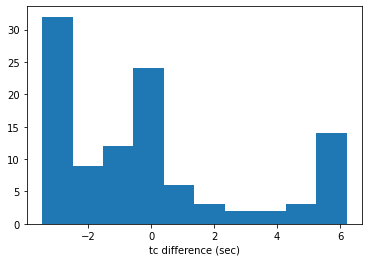

In [63]:
k = 50
tc1, ediff1 = jttv2.get_ttvs(samples['elements'][k], jnp.hstack([1., samples['mass'][k]]))
plt.xlabel("tc difference (sec)")
plt.hist(np.array(samples['tcmodel'][k] - tc1)*86400.)